<a href="https://colab.research.google.com/github/happy-jihye/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GAN 실습

- [Generative Adversarial Networks (NIPS 2014)](https://arxiv.org/abs/1406.2661)

> - 2021/03/12 Happy-jihye
> - **Reference** : [eriklindernoren/PyTorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py)


In [5]:
import torch
import torch.nn as nn

import numpy as np

# for MNIST data
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

##  Generator

In [6]:
# image 

channels = 1
img_size = 28

img_shape = (channels, img_size, img_size)

In [7]:
# dimensionality of the latent space
# latent vector를 추출하기 위한 noise 분포의 dimension (정규분포를 따름)
latent_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # generater의 model은 여러개의 block을 쌓아서 만들어짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z): # noise vector : z
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

### MINIST dataset

In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

#### <b>모델 학습 및 샘플링</b>

* 학습을 위해 생성자와 판별자 모델을 초기화합니다.
* 적절한 하이퍼 파라미터를 설정합니다.

In [ ]:
''' Hyper parameter '''
# learning rate
lr = 0.0002

# decay of first order momentum of gradient
b1 = 0.5
b2 = 0.999


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss function
adversarial_loss = nn.BCELoss()

# Adam Optimizer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [ ]:
# GPU
cuda = True if torch.cuda.is_available() else False

if cuda : 
  generator.cuda()
  discriminator.cuda()
  adversarial_loss.cuda()

# Training

In [ ]:
import time

# number of epochs of training
n_epochs = 200 

# interval between image samples
sample_interval = 2000 

start_time = time.time()

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        # real은 1로, fake는 0으로
        real = Variable(Tensor(imgs.size(0), 1).fill_(1,0), requires_grad = False) 
        fake = Variable(Tensor(imgs.size(0), 1).fill_(1,0), requires_grad = False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/200] [D loss: 0.454529] [G loss: 0.746830] [Elapsed time: 10.27s]
[Epoch 1/200] [D loss: 0.407060] [G loss: 1.642434] [Elapsed time: 20.66s]
[Epoch 2/200] [D loss: 0.301878] [G loss: 1.230006] [Elapsed time: 30.84s]
[Epoch 3/200] [D loss: 0.287636] [G loss: 2.337830] [Elapsed time: 40.75s]
[Epoch 4/200] [D loss: 0.254162] [G loss: 1.601647] [Elapsed time: 51.29s]
[Epoch 5/200] [D loss: 0.241826] [G loss: 1.394916] [Elapsed time: 61.33s]
[Epoch 6/200] [D loss: 0.175050] [G loss: 2.742474] [Elapsed time: 71.22s]
[Epoch 7/200] [D loss: 0.233544] [G loss: 1.333334] [Elapsed time: 81.19s]
[Epoch 8/200] [D loss: 0.288222] [G loss: 1.179692] [Elapsed time: 91.26s]
[Epoch 9/200] [D loss: 0.102411] [G loss: 2.092275] [Elapsed time: 101.21s]
[Epoch 10/200] [D loss: 0.176065] [G loss: 1.834861] [Elapsed time: 111.47s]
[Epoch 11/200] [D loss: 0.218729] [G loss: 2.124454] [Elapsed time: 121.63s]
[Epoch 12/200] [D loss: 0.433043] [G loss: 3.164089] [Elapsed time: 131.81s]
[Epoch 13/200] [D 

* 생성된 이미지 예시를 출력합니다.

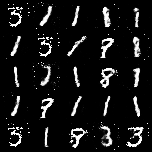

In [ ]:
from IPython.display import Image

Image('92000.png')